In [41]:
from urllib.request import urlopen
import ssl
import json

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

dataTrain = urlopen("https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_001.json", context=ctx).read().decode()
dataTest = urlopen("https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/test/dialogues_001.json", context=ctx).read().decode()

myJsonTrain = json.loads(dataTrain)
myJsonTest = json.loads(dataTest)
print (json.dumps(myJsonTrain[0], indent=1)[0:100])
print (json.dumps(myJsonTest[0], indent=1)[0:100])

{
 "dialogue_id": "PMUL4398.json",
 "services": [
  "restaurant",
  "hotel"
 ],
 "turns": [
  {
   "
{
 "dialogue_id": "MUL0484.json",
 "services": [
  "attraction",
  "train"
 ],
 "turns": [
  {
   "f


In [42]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [43]:
# filter
def filter(data):
  res = []

  for i, obj in enumerate(data):
      turns = obj.get("turns", None)
      for turn in turns:
          if turn is not None:
              utterance = turn.get("utterance", None)
              if utterance is not None:
                  frames = turn.get("frames", None)
                  if frames is not None:
                      for frame in frames: 
                          state = frame.get("state", None)
                          if state is not None:
                              active_intent = state.get("active_intent", None)
                              if active_intent is not None:
                                  if active_intent == "find_restaurant":
                                    active_intent = 1
                                  elif active_intent == "book_restaurant":
                                    active_intent = 2
                                  else:
                                    active_intent = 0

                                  res.append((utterance, active_intent))
                                  break

  return res

train_dataset = filter(myJsonTrain)
for i, elem in enumerate(train_dataset):
      print(elem)
      if i > 30:
        print("--------------------")
        break
test_dataset = filter(myJsonTest)
for i, elem in enumerate(test_dataset):
      print(elem)
      if i > 30:
        print("--------------------")
        break


train_dataset = tf.data.Dataset.from_tensor_slices(
      (
          tf.cast([text for text, label in train_dataset], tf.string),
          tf.cast([label for text, label in train_dataset], tf.int32)
      )
  )

test_dataset = tf.data.Dataset.from_tensor_slices(
      (
          [text for text, label in test_dataset],
          [label for text, label in test_dataset]
      )
  )

BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

('i need a place to dine in the center thats expensive', 1)
('Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?', 1)
('Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?', 1)
('Yes. Can you book it for me?', 0)
('i want to book it for 2 people and 2 nights starting from saturday.', 0)
('That is all I need to know. Thanks, good bye.', 0)
('Guten Tag, I am staying overnight in Cambridge and need a place to sleep. I need free parking and internet.', 0)
("No, but I'd really like to be on the south end of the city. Do any of those fit the bill?", 0)
("No I don't care about the price. Which one do you recommend?", 0)
('Yes, book it for 4 people and 4 nights starting from tuesday.', 0)
('How about for 3 nights?', 0)
('Great. I am all set then. Have a nice day. Bye.', 0)
('Hi there! Can you give me some info on Cityroomz?', 0)
('Yes please. I need it for 7 people for 3 nights startin

In [44]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [45]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy())
  print()
  print('labels: ', label.numpy())

texts:  [b'i need a place to dine in the center thats expensive'
 b'Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?'
 b'Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?'
 b'Yes. Can you book it for me?'
 b'i want to book it for 2 people and 2 nights starting from saturday.'
 b'That is all I need to know. Thanks, good bye.'
 b'Guten Tag, I am staying overnight in Cambridge and need a place to sleep. I need free parking and internet.'
 b"No, but I'd really like to be on the south end of the city. Do any of those fit the bill?"
 b"No I don't care about the price. Which one do you recommend?"
 b'Yes, book it for 4 people and 4 nights starting from tuesday.'
 b'How about for 3 nights?'
 b'Great. I am all set then. Have a nice day. Bye.'
 b'Hi there! Can you give me some info on Cityroomz?'
 b'Yes please. I need it for 7 people for 3 nights starting on tuesday.'
 b'I would like

In [46]:
# encoder
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])
print("vocab size:", len(vocab))

['' '[UNK]' 'i' 'the' 'a' 'to' 'for' 'you' 'need' 'and' 'that' 'in'
 'please' 'can' 'me' 'is' 'on' 'thank' 'like' 'it']
vocab size: 1385


In [47]:
encoded_example = encoder(example).numpy()
encoded_example

array([[   2,    8,    4, ...,    0,    0,    0],
       [  73,  704,   21, ...,    0,    0,    0],
       [  89,   96,   59, ...,    0,    0,    0],
       ...,
       [  49,    4,  472, ...,  952,   42, 1147],
       [  20,    2,   22, ...,    0,    0,    0],
       [  15,   19,  253, ...,    0,    0,    0]])

In [48]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'i need a place to dine in the center thats expensive'
Round-trip:  i need a place to dine in the center thats expensive                 

Original:  b'Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?'
Round-trip:  any sort of food would be fine as long as it is a bit expensive could i get the phone number for your recommendation    

Original:  b'Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?'
Round-trip:  sounds good could i get that phone number also could you recommend me an expensive hotel            



In [49]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [50]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


In [51]:
# predict on a sample text without padding.

sample_text = ("I'm looking for a local place to dine in the centre that serves chinese food.")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.33417222 0.33359656 0.33223122]


In [52]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.33417222 0.33359656 0.33223122]


In [53]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [54]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30, verbose=1)

Epoch 1/10
56/56 [==============================] - 28s 213ms/step - loss: 1.0543 - accuracy: 0.7575 - val_loss: 0.9737 - val_accuracy: 0.7906
Epoch 2/10
56/56 [==============================] - 7s 118ms/step - loss: 0.8411 - accuracy: 0.7796 - val_loss: 0.7026 - val_accuracy: 0.7906
Epoch 3/10
56/56 [==============================] - 7s 118ms/step - loss: 0.7165 - accuracy: 0.7796 - val_loss: 0.6403 - val_accuracy: 0.7906
Epoch 4/10
56/56 [==============================] - 7s 119ms/step - loss: 0.6421 - accuracy: 0.7793 - val_loss: 0.5770 - val_accuracy: 0.7906
Epoch 5/10
56/56 [==============================] - 7s 118ms/step - loss: 0.5670 - accuracy: 0.7833 - val_loss: 0.5056 - val_accuracy: 0.8005
Epoch 6/10
56/56 [==============================] - 7s 117ms/step - loss: 0.4842 - accuracy: 0.8173 - val_loss: 0.4685 - val_accuracy: 0.8328
Epoch 7/10
56/56 [==============================] - 7s 118ms/step - loss: 0.4377 - accuracy: 0.8493 - val_loss: 0.4507 - val_accuracy: 0.8469
Epoch

In [55]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

61/61 [==============================] - 2s 30ms/step - loss: 0.4169 - accuracy: 0.8621
Test Loss: 0.41686728596687317
Test Accuracy: 0.8620510101318359


In [56]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_dataset)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_dataset], axis=0)
print(classification_report(predicted_categories, true_categories, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3277
           1       0.62      0.62      0.62       565
           2       0.00      0.00      0.00         0

    accuracy                           0.86      3842
   macro avg       0.54      0.51      0.52      3842
weighted avg       0.93      0.86      0.90      3842



(0.0, 1.0888698428869248)

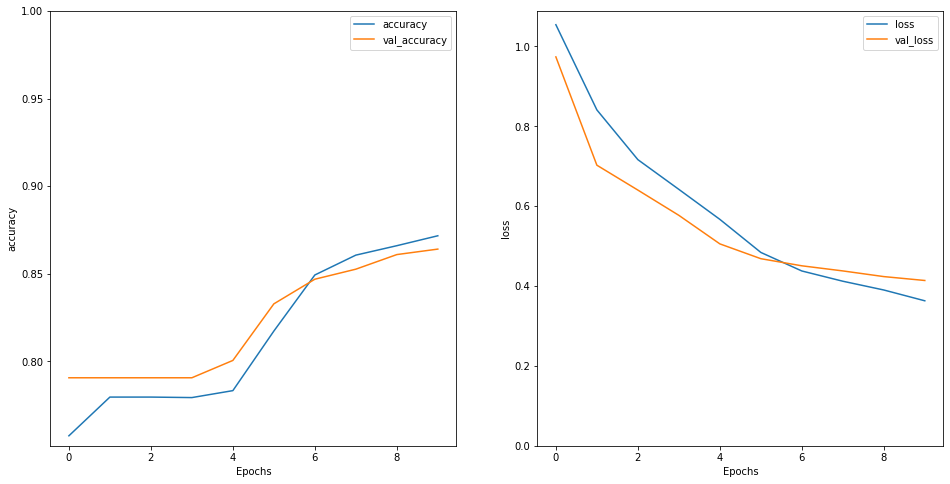

In [57]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [58]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [59]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [60]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
56/56 [==============================] - 33s 213ms/step - loss: 1.0581 - accuracy: 0.7340 - val_loss: 0.9812 - val_accuracy: 0.7906
Epoch 2/10
56/56 [==============================] - 7s 118ms/step - loss: 0.8502 - accuracy: 0.7796 - val_loss: 0.7047 - val_accuracy: 0.7906
Epoch 3/10
56/56 [==============================] - 7s 118ms/step - loss: 0.7235 - accuracy: 0.7796 - val_loss: 0.6425 - val_accuracy: 0.7906
Epoch 4/10
56/56 [==============================] - 7s 117ms/step - loss: 0.6479 - accuracy: 0.7796 - val_loss: 0.5765 - val_accuracy: 0.7906
Epoch 5/10
56/56 [==============================] - 7s 117ms/step - loss: 0.5677 - accuracy: 0.7816 - val_loss: 0.5027 - val_accuracy: 0.7995
Epoch 6/10
56/56 [==============================] - 7s 118ms/step - loss: 0.4888 - accuracy: 0.8227 - val_loss: 0.4640 - val_accuracy: 0.8359
Epoch 7/10
56/56 [==============================] - 7s 118ms/step - loss: 0.4418 - accuracy: 0.8516 - val_loss: 0.4414 - val_accuracy: 0.8510
Epoch

In [61]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

61/61 [==============================] - 2s 31ms/step - loss: 0.4026 - accuracy: 0.8623
Test Loss: 0.40259695053100586
Test Accuracy: 0.8623113036155701


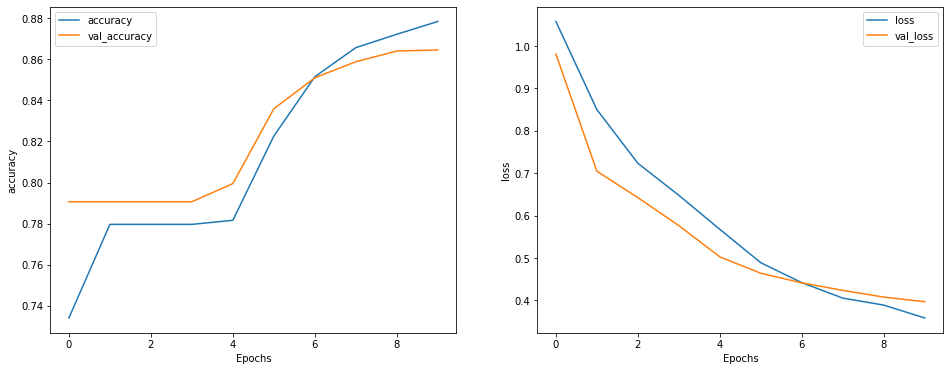

In [62]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [63]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_dataset)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_dataset], axis=0)
print(classification_report(predicted_categories, true_categories, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      3254
           1       0.64      0.62      0.63       588
           2       0.00      0.00      0.00         0

    accuracy                           0.86      3842
   macro avg       0.54      0.51      0.52      3842
weighted avg       0.93      0.86      0.89      3842

